In [2]:
# import data_science as ds 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mplpatches
from scipy import stats
import math

# FUNCTIONS
#reads in all the sample names used as keys in the dictionary
def getFileNames(file, exp):
    samples_list = []
    inFile = open(file, 'r')
    for line in inFile:
        splitLine=line.strip().split('\n')
        name=splitLine[0]
        if exp in name:
            samples_list.append(name)
#         elif exp not in name:
#             print(name)
    inFile.close()
    return samples_list
    
#normalizes for sequencing depth CPM counts per million and for enhancer length KB (kilobase)
def normalize_CPKM(exp_dict):
    for name, counts in exp_dict.items():
        count_per_enhancer = [x[0] for x in counts]
        total_counts_per_sample = sum(count_per_enhancer)
        cpkm_vals = [(tup[0] / (tup[1] * total_counts_per_sample)) * 10**9 for tup in counts]
        exp_dict[name] = cpkm_vals


def run_ds_on_exp(samples_dir, rel_path, exp):
    sampleDict = {}
    samples = getFileNames(samples_dir, exp)
    for sample in samples:
        cts_counts_wlength(rel_path, sample, sampleDict)
    
    #rename dictionary keys to specify conditions and replicates         
    rename_keys(sampleDict)

    #normalize the data using CPKM
    normDict = norm(sampleDict, exp)

    return normDict

def norm(sampleDict, exp):
    #normalize, combine replicates
    normalize_CPKM(sampleDict)
    replicates_cpkm = combine_replicates_cpkm(sampleDict, exp)
#     logged_replicates = log_replicates_cpkm(replicates_cpkm)
    return replicates_cpkm 

# def log_replicates_cpkm(replicates):
#     log_replicates_cpkm = {}
#     for sample_name, counts in replicates.items():
#         log_replicates_cpkm[sample_name] = [np.log(x+1) for x in counts]
#     return log_replicates_cpkm
 
def rename(sampleDict, r1, r2, condition):
    #dictionary[new_key] = dictionary.pop(old_key)
    #https://stackoverflow.com/questions/4406501/change-the-name-of-a-key-in-dictionary
    sampleDict['En_'+condition+'_r1'] = sampleDict.pop(r1+'_end')
    sampleDict['Fb_'+condition+'_r1'] = sampleDict.pop(r1+'_fib')
    sampleDict['My_'+condition+'_r1'] = sampleDict.pop(r1+'_mye')

    sampleDict['En_'+condition+'_r2'] = sampleDict.pop(r2+'_end')
    sampleDict['Fb_'+condition+'_r2'] = sampleDict.pop(r2+'_fib')
    sampleDict['My_'+condition+'_r2'] = sampleDict.pop(r2+'_mye')

def rename_keys(sampleDict):
    rename(sampleDict, 'Sample1', 'Sample2', 'Sham')
    rename(sampleDict, 'Sample3', 'Sample4', 'TAC')
    rename(sampleDict, 'Sample5', 'Sample6', 'JQ1W')
    rename(sampleDict, 'Sample7', 'Sample8', 'JQ1')
        
def combine(sampleDict, cellType, condition):
    combined = []
    for s1,s2 in zip(sampleDict[cellType+'_'+condition+'_r1'],sampleDict[cellType+'_'+condition+'_r2']):
        combined.append(s1+s2)
    return combined

#combine replicate cpkm values        
def combine_replicates_cpkm(sampleDict, exp):
    replicateDict = {}  
    replicateDict[exp +'_Endo_Sham'] = combine(sampleDict, 'En', 'Sham')
    replicateDict[exp +'_Fb_Sham'] = combine(sampleDict, 'Fb', 'Sham')
    replicateDict[exp +'_Mye_Sham'] = combine(sampleDict, 'My', 'Sham')
    
    replicateDict[exp +'_Endo_TAC'] = combine(sampleDict, 'En', 'TAC')
    replicateDict[exp +'_Fb_TAC'] = combine(sampleDict, 'Fb', 'TAC')
    replicateDict[exp +'_Mye_TAC'] = combine(sampleDict, 'My', 'TAC')
    
    replicateDict[exp +'_Endo_JQ1W'] = combine(sampleDict, 'En', 'JQ1W')
    replicateDict[exp +'_Fb_JQ1W'] = combine(sampleDict, 'Fb', 'JQ1W')
    replicateDict[exp +'_Mye_JQ1W'] = combine(sampleDict, 'My', 'JQ1W')
    
    replicateDict[exp +'_Endo_JQ1'] = combine(sampleDict, 'En', 'JQ1')
    replicateDict[exp +'_Fb_JQ1'] = combine(sampleDict, 'Fb', 'JQ1')
    replicateDict[exp +'_Mye_JQ1'] = combine(sampleDict, 'My', 'JQ1')
    
    return replicateDict
    
   
       
#stores cell type specific (cts) counts and length of enhancer as tuples into a dictionary using samples as key
def cts_counts_wlength(rel_path, file, exp_dict):
    counts_endo = []
    counts_fib = []
    counts_mye = []
    inFile = open(rel_path + file, 'r')
    for line in inFile:
        splitLine=line.strip().split('\t')
        start_pos = int(splitLine[1])
        end_pos = int(splitLine[2])
        length = (end_pos - start_pos)+1
        val_endo = int(splitLine[3])
        val_fib = int(splitLine[4])
        val_mye = int(splitLine[5])
        counts_endo.append((val_endo,length))
        counts_fib.append((val_fib,length))
        counts_mye.append((val_mye,length))
    inFile.close()
    sample = file[:7]
#     print(len(counts_endo), len(counts_fib), len(counts_mye))
    exp_dict[sample + '_end'] = counts_endo
    exp_dict[sample + '_fib'] = counts_fib
    exp_dict[sample + '_mye'] = counts_mye

def merge(expDict, cellType, exp):
    count = 0
    mergeList = []
    for w,x,y,z in zip(expDict[exp+'_'+cellType+'_Sham'], 
                       expDict[exp+'_'+cellType+'_TAC'], 
                       expDict[exp+'_'+cellType+'_JQ1'], 
                       expDict[exp+'_'+cellType+'_JQ1W']):
        mergeList.append([w,x,y,z])
#         if w== 0.0 and x ==0.0 and y ==0.0 and z == 0.0:
#             count+=1
#     print(exp, cellType, count)
    return mergeList

def plot_cellType(cellType_rna, cellType_atac):
    corr = []
    for r, a in zip(cellType_rna, cellType_atac):
#         corr.append(np.log(stats.pearsonr(r, a)[0]+1))
        coeff = stats.pearsonr(r, a)[0]
        if np.isnan(coeff):
            corr.append(0)
        else:
            corr.append(stats.pearsonr(r, a)[0])
#     print(corr)
    return corr  

def aggregate_counts_exp(celltype_counts):
    #takes a dictionary that has enhancer : sham, TAC, JQ1, JQ1w
    counts = []
    for cpkm in celltype_counts:
        #for each enhancer in celltype
        #sum the counts across conditions
        sham_cpkm = cpkm[0]
        tac_cpkm = cpkm[1]
        jq1_cpkm = cpkm[2]
        jq1w_cpkm = cpkm[3]
        agg_count = sham_cpkm + tac_cpkm +jq1_cpkm + jq1w_cpkm
        counts.append(agg_count)
#     print(counts)
    return counts

def counts_vs_corr(cellType, cellType_rna, cellType_atac, ax, bins, labels, exp_count):
    
    corr = plot_cellType(cellType_rna, cellType_atac)
#     corrdf = pd.DataFrame(corr)
#     corrdf.to_csv('../../../data/projects/morin/corr.csv')
#     print(corr)
    cellType_dict = {}
    cellType_dict['Pearson\'s Correlation Coefficient'] = corr
    if exp_count == 'RNAseq CPKM':
        cellType_dict['counts_agg'] = aggregate_counts_exp(cellType_rna)
        print("RNA counts on x axis")
    else:
        cellType_dict['counts_agg'] = aggregate_counts_exp(cellType_atac)
        print("ATAC counts on x axis")
    
    df = pd.DataFrame(cellType_dict)
#     df.to_csv('../../../data/projects/morin/df.csv')
#     print(df['counts_agg'].describe())
#     df[exp_count] = pd.qcut(df['counts_agg'], q=4, precision= 1)
    df[exp_count] = pd.cut(df['counts_agg'], bins=cut_bins, labels=cut_labels, 
                                   right=False)
    print(df)
    sns.set(style="whitegrid")
    vp = sns.violinplot(x=exp_count, y="Pearson\'s Correlation Coefficient", 
                        data=df, inner=None)
    sp = sns.swarmplot(x=exp_count, y="Pearson\'s Correlation Coefficient", 
                       data=df, color=".2",edgecolor='black')
    ax.set_title(cellType)
    ax = vp
    print(df[exp_count].value_counts())
    return vp  


In [3]:
#----------------MAIN PROGRAM
rel_path = "../../../data/projects/morin/Counts/cellType_specific_counts/"
#store data in dictionary using key:sample, value: log(count+1) for CPM normalization
#and value: (log(count+1), length) for CPKM normalization


#list of filenames with counts 
samples_dir = "../../../data/projects/morin/cellType_specific_counts.txt"

#normalizes, adds replicates, keeps values unlogged
rnaDict= run_ds_on_exp(samples_dir, rel_path, "RNA")
# print(rnaDict)

#normalize atac data
atacDict= run_ds_on_exp(samples_dir, rel_path, "ATAC")
# print(atacDict)

#merge conditions within celltypes for RNA
endo_rna = merge(rnaDict, 'Endo', 'RNA')
fib_rna = merge(rnaDict, 'Fb', 'RNA')
mye_rna = merge(rnaDict, 'Mye', 'RNA')
# print(mye_rna[290])
 

#merge conditions within celltypes for ATAC
endo_atac = merge(atacDict, 'Endo', 'ATAC')
fib_atac = merge(atacDict, 'Fb', 'ATAC')
mye_atac = merge(atacDict, 'Mye', 'ATAC')



/pollard/home/smorin/miniconda3/envs/r-environment/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


RNA counts on x axis
     Pearson's Correlation Coefficient  counts_agg RNAseq CPKM
0                            -0.967341  508.866878    100-1000
1                            -0.866429  134.186328    100-1000
2                             0.205665   17.682240       10-20
3                             0.855188   96.793037      20-100
4                             0.233643   36.558773      20-100
..                                 ...         ...         ...
465                           0.000000    0.000000           0
466                          -0.471813  394.206279    100-1000
467                          -0.624959   22.455353      20-100
468                          -0.548233  119.075441    100-1000
469                          -0.300328    9.152030        1-10

[470 rows x 3 columns]
100-1000      214
20-100        110
1000-10000     82
10-20          23
1-10           22
>10000         14
0               5
Name: RNAseq CPKM, dtype: int64


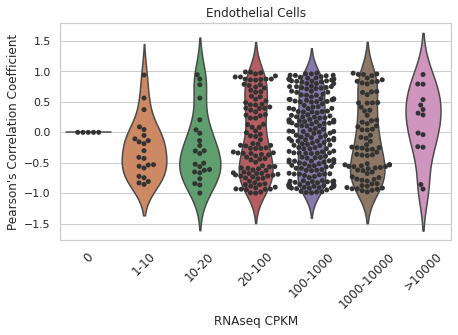

In [43]:

#------------------RNA reads vs Pearson's Correlation
cut_bins=[0,1,10,20,100, 1000, 10000, 100000]
cut_labels =["0", "1-10", "10-20", "20-100", "100-1000", "1000-10000", ">10000"]
# cut_bins=[0,1,10,20,100000]
# cut_labels =["0", "1-10", "10-20", ">20"]

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(7, 4), sharex=True, sharey=True)
plt.xticks(rotation=45, fontsize=12)
vp = counts_vs_corr("Endothelial Cells", endo_rna, endo_atac, axs, cut_bins, cut_labels, 'RNAseq CPKM')


/pollard/home/smorin/miniconda3/envs/r-environment/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


RNA counts on x axis
     Pearson's Correlation Coefficient   counts_agg RNAseq CPKM
0                            -0.372260  2904.132441  1000-10000
1                             0.515093   122.040514    100-1000
2                            -0.162443    55.635194      20-100
3                             0.821587    36.885606      20-100
4                             0.138347    32.404992      20-100
..                                 ...          ...         ...
465                          -0.587125    28.325551      20-100
466                           0.437835   267.225393    100-1000
467                           0.046886    58.209484      20-100
468                           0.312277   174.939006    100-1000
469                           0.847345     6.136049        1-10

[470 rows x 3 columns]
100-1000      222
20-100        126
1000-10000     80
10-20          16
1-10           10
>10000          9
0               6
Name: RNAseq CPKM, dtype: int64


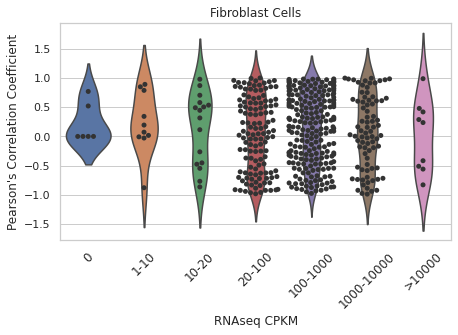

In [44]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(7, 4), sharex=True, sharey=True)
plt.xticks(rotation=45, fontsize=12)
vp = counts_vs_corr("Fibroblast Cells", fib_rna, fib_atac, axs, cut_bins, cut_labels, 'RNAseq CPKM')

/pollard/home/smorin/miniconda3/envs/r-environment/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


RNA counts on x axis
     Pearson's Correlation Coefficient  counts_agg RNAseq CPKM
0                            -0.633861  268.387118    100-1000
1                            -0.281279   24.527672      20-100
2                             0.273395    3.777140        1-10
3                            -0.464224   40.761295      20-100
4                             0.837083   13.614677       10-20
..                                 ...         ...         ...
465                          -0.375934   10.275430       10-20
466                           0.311926  371.329866    100-1000
467                          -0.101290   15.788677       10-20
468                          -0.392541   41.293012      20-100
469                           0.000000    0.000000           0

[470 rows x 3 columns]
100-1000      172
20-100        120
1000-10000     65
1-10           39
10-20          38
0              25
>10000          9
Name: RNAseq CPKM, dtype: int64


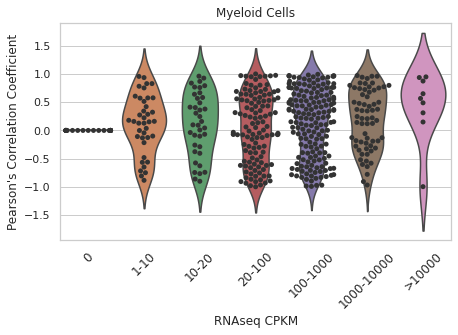

In [45]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(7, 4), sharex=True, sharey=True)
plt.xticks(rotation=45, fontsize=12)
vp = counts_vs_corr("Myeloid Cells", mye_rna, mye_atac, axs, cut_bins, cut_labels, 'RNAseq CPKM')

In [4]:
count = 0
yes_list = []
for endo, fb, mye in zip(endo_rna, fib_rna, mye_rna):
#     print(endo)
    l = [sum(endo), sum(fb),sum(mye)]
    sum(l)
    if sum(l) > 20:
#     if sum(endo)  > 20 or sum(fb) > 20 or sum(mye) > 20:
#         print(count, "yes")
        yes_list.append(count)
    count+=1
print(len(yes_list))
print(yes_list)


462
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 98, 99, 100, 101, 102, 103, 104, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223